##### Notebook 02: Analysis

# US FOMC Communication Interest Rate Forecaster

### Contents:
- [01: Spell Checker](#01:-Spell-Checker)
- [02: Import Data](#02:-Import-Data)
- [03: Data Modifications](#03:-Data-Modification)
- [04: Target Value Creation](#04:-Target-Value-Creation)
- [05: Modelling](#05:-Modelling)
- [06: Model Reivew](#06:-Model-Reivew)
- [07: Final Model Tuning and Partial Data Testing](#07:-Final-Model-Tuning-and-Partial-Data-Testing)
- [08: Review of Results and Moving Average Addition](#08:-Review-of-Results-and-Moving-Average-Addition)
- [09: Decreasing the Training Sample](#09:-Decreasing-the-Training-Sample)
- [10: Final Model Review and Conclusion](#10:-Final-Model-Review-and-Conclusion)


In [31]:
## Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from symspellpy.symspellpy import SymSpell, Verbosity
from nltk.stem import SnowballStemmer
from xgboost import XGBClassifier, plot_importance
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora, models
import pyLDAvis.gensim
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
%matplotlib inline

### 01: Spell Checker
Optional spell checker function.  This only needs to be ran on new documents or to improve spelling checking on existing cells.  Errors exist in the files from the PDF text extractor, it works imperfectly.  The sym spell library has several parameters for throttling the accuracy of the spell checking, based on computational resources and time available.  For this project, a light spell check pass was completed only.  Typos and word fragments still remain.  <br>
<br>
This section is optional, and due to the time constraint, should only be run if needed for another spell check pass.  The spell checked text will be saved over the CSV as it progresses.

In [ ]:
## Import texts that already have a partial spell check completed
## Useful if processing spell checking one part a time

df_texts = pd.read_csv('./data/df_texts_spellchecked.csv')
df_texts.drop('Unnamed: 0', inplace=True, axis=1)
df_texts['date'] = pd.to_datetime(df_texts['date'])
df_texts.head()

## Text rows completed so far: 592

In [234]:
df_texts.shape

(644, 1)

In [ ]:
## Spell check function
## Use the counter to mark which row was last completed, useful if running the spell check in partial chunks

counter = 593
# Dictionary path - Change to filepath of project location
dictionary_path = 'C:/sdm/GIT/DSI/Capstone/frequency_dictionary_en_82_765.txt'

initial_capacity = 83000 # increase to improve accuracy at cost of speed
max_edit_distance_dictionary = 1 # increase to improve accuracy at cost of speed
prefix_length = 7 # increase to improve accuracy at cost of speed
term_index = 0  # column of the term in the dictionary text file
count_index = 1  # column of the term frequency in the dictionary text file

for x in range(593,644):
    sym_spell = SymSpell(initial_capacity, max_edit_distance_dictionary,
                         prefix_length)
    sym_spell.load_dictionary(dictionary_path, 0, 1)
    if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
        print("Dictionary file not found")
    
    string_variable = sym_spell.word_segmentation(df_texts.iloc[x][1])
    
    df_texts.iloc[x][1] = string_variable.corrected_string
    print(counter)
    counter += 1
    df_texts.to_csv('./data/df_texts_spellchecked.csv', sep=',')

### 02: Import Data
Interest rate and FOMC communications.

In [5]:
## Interest Rates

df_int= pd.read_csv('./data/data.csv')
df_int.rename(index=str, columns={'Unnamed: 0': 'date'}, inplace=True)
df_int['date'] = pd.to_datetime(df_int['date'])

In [8]:
## FOMC Communications

df_texts = pd.read_csv('./data/df_texts_spellchecked.csv')
df_texts.drop('Unnamed: 0', inplace=True, axis=1)
df_texts['date'] = pd.to_datetime(df_texts['date'])
df_texts.head()

,date,text
0,2018-01-17,The Beige Book Summary of Commentary on Curren...
1,2018-03-07,The Beige Book Summary of Commentary on Curren...
2,2018-04-18,The Beige Book Summary of Commentary on Curren...
3,2018-05-30,The Beige BookSummary of Commentary on Current...
4,2018-06-13,Minutes of the Federal Open Market Committ...


### 03: Data Modification
Interest rates are provided for daily rates, this needs to be converted to monthly rates to match FOMC communication dates.  The mean monthly interest rate will be used.  After, the six month following rate change will be calculated.
1. Mean interest rate conversion, both dataframes combined
2. Six month difference calculated

In [9]:
## Convert to monthly data, combine to single dataframe

df_int.set_index(['date'], inplace=True)
df_int = df_int.resample("M").mean()
df_texts.set_index(['date'], inplace=True)
df_texts.sort_index(inplace=True)
df_texts.index = df_texts.index + pd.offsets.MonthBegin(1)
df_int.index = df_int.index + pd.offsets.MonthBegin(1)
df_complete = df_texts.join(df_int)
df_complete.head(5)

,text,rate
date,,
1960-02-01,A meeting of the Federal Open Market Committee...,3.991935
1960-03-01,A meeting of the Federal Open Market Committee...,3.965517
1960-04-01,A meeting of the Federal Open Market Committee...,3.838710
1960-05-01,A meeting of the Federal Open Market Committee...,3.916667
1960-06-01,A meeting of the Federal Open Market Committee...,3.846774


In [11]:
## Calculate 6 month change

df_temp = df_complete.copy()
df_temp['change_6'] = df_complete['rate'].diff(6)
df_temp.head(10)

,text,rate,change_6
date,,,
1960-02-01,A meeting of the Federal Open Market Committee...,3.991935,NaN
1960-03-01,A meeting of the Federal Open Market Committee...,3.965517,NaN
1960-04-01,A meeting of the Federal Open Market Committee...,3.838710,NaN
1960-05-01,A meeting of the Federal Open Market Committee...,3.916667,NaN
1960-06-01,A meeting of the Federal Open Market Committee...,3.846774,NaN
1960-07-01,A meeting of the Federal Open Market Committee...,3.316667,NaN
1960-08-01,A meeting of the Federal Open Market Committee...,3.225806,-0.766129
1960-09-01,A meeting of the Federal Open Market Committee...,2.975806,-0.989711
1960-10-01,A meeting of the Federal Open Market Committee...,2.600000,-1.238710


In [195]:
## Shift the interest rate change records up
df_temp['change_6'] = df_temp['change_6'].shift(-6)

### 04: Target Value Creation
Target value will not be the exact interest rate, it will be the following 6 month sentiment (hawkish, dovish, neutral).  Since the actual interest rate varies day to day by slight amounts, a threshold will be set that the 6 month change must exceed for it to be considered a change.  

In [200]:
y = df_temp[['change_6']]

# Drop the NAN columns
text = df_temp[:-6]
y = y[:-6]

y_threshold = 0.25

# Create y-target, with threshold for minimum change
y.mask(y > y_threshold, 1, inplace=True)
y.mask(y < -y_threshold, -1, inplace=True)
y.mask((y > -y_threshold) & (y < 0.25), 0, inplace=True)
y.head()

,change_6
date,
1960-02-01,-1.0
1960-03-01,-1.0
1960-04-01,-1.0
1960-05-01,-1.0
1960-06-01,-1.0


In [201]:
text.shape

(638, 3)

In [202]:
y.shape

(638, 1)

In [203]:
## Check for class balance

y['change_6'].value_counts()

 1.0    243
-1.0    204
 0.0    191
Name: change_6, dtype: int64

### 05: Modelling
This will include preprocessing, model fitting, model accuracy testing.
1. Lower case
2. Stemming
3. TFIDF vectorizer
4. Modelling

In [143]:
## Lower case

text['text'] = [i.lower() for i in text['text']]

In [144]:
## Stemming

snow = SnowballStemmer('english',)
text['text'] = [snow.stem(i) for i in text['text']]

In [204]:
## Save stemmed tech to CSV, or load stemmed text from CSV
## Shortcut for model evaluation and TFIDF parameter changes

# Save stemmed documents to CSV
# text.to_csv('./data/text_stemmed.csv', sep=',')

# Load texts from CSV
text = pd.read_csv('./data/text_stemmed.csv')

In [220]:
## Instantiate a TFIDF vectorizer

vect = TfidfVectorizer(stop_words='english', 
                       max_features = 6000, 
                       ngram_range=(2,5),
                       token_pattern='[a-zA-Z]+')
X_text = vect.fit_transform(text['text'])

# Create a DataFrame to examine
text = pd.DataFrame(X_text.toarray(), columns=vect.get_feature_names())
text_tfidf = text.copy() # create backup of TFIDF text for later use
text.head()

,acceptances period,accordance following,according moody,according moody s,according moody s bond,according moody s bond ratings,according preliminary,account accordance,account accordance following,account balance,...,yield curves,yield spreads,yield year,york authorized,york authorized directed,york bank,york city,york mr,york philadelphia,york state
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.012958,0.010921,0.014804,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.009264,...,0.0,0.0,0.0,0.0,0.0,0.021442,0.000000,0.024497,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.052428,0.000000,0.014974,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.014166,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.024714,0.000000,0.014117,0.0,0.0


In [237]:
## XGBoost model fitting and testing

xgb_model = XGBClassifier(objective='multi:softmax',
                          max_depth=3,
                          num_classes=3)

train_scores = []
test_scores = []

for x in range(1,5):
    X_train, X_test, y_train, y_test = train_test_split(text, y)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    test_score = round(xgb_model.score(X_test, y_test),2)
    train_score = round(xgb_model.score(X_train, y_train),2)
    # print(f'{xgb_model.get_params}')
    print(f'Run {x}... train: {train_score}, test: {test_score}')
    train_scores.append(train_score)
    test_scores.append(test_score)

print(f'Train average: {np.mean(train_scores)}')
print(f'Test average: {np.mean(test_scores)}')

Run 1... train: 1.0, test: 0.66
Run 2... train: 1.0, test: 0.68
Run 3... train: 1.0, test: 0.62
Run 4... train: 1.0, test: 0.66
Train average: 1.0
Test average: 0.655


### 06: Model Reivew
1. Feature Importance
2. LDA
3. Plotting Results

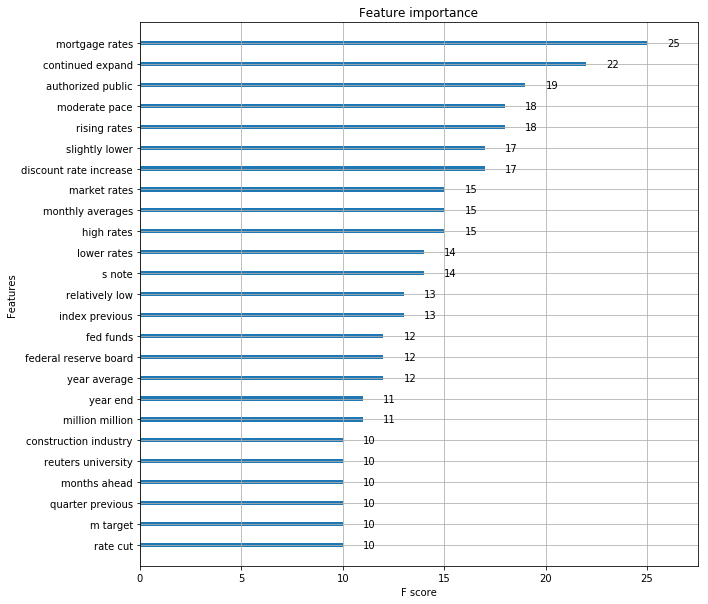

In [207]:
## Feature importance

fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(xgb_model, max_num_features = 25, ax=ax);

In [208]:
## Re-import the documents for LDA
## Clean dataframe to work with, due to the need for splitting the text into categories

text = pd.read_csv('./data/text_stemmed.csv')
text.head()

,date,text,rate,change_6
0,1960-08-01,a meeting of the federal open market committee...,3.225806,-0.766129
1,1960-09-01,a meeting of the federal open market committee...,2.975806,-0.989711
2,1960-10-01,a meeting of the federal open market committee...,2.600000,-1.238710
3,1960-11-01,a meeting of the federal open market committee...,2.467742,-1.448925
4,1960-12-01,a meeting of the federal open market committee...,2.441667,-1.405108


In [209]:
## Recreate the y-targets
# y_threshold = 0.25
text['y'] = text['change_6']

# Create y-target, with threshold for minimum change
text['y'].mask(text['y'] > y_threshold, 1, inplace=True)
text['y'].mask(text['y'] < -y_threshold, -1, inplace=True)
text['y'].mask((text['y'] > -y_threshold) & (text['y'] < 0.25), 0, inplace=True)
text.head()

,date,text,rate,change_6,y
0,1960-08-01,a meeting of the federal open market committee...,3.225806,-0.766129,-1.0
1,1960-09-01,a meeting of the federal open market committee...,2.975806,-0.989711,-1.0
2,1960-10-01,a meeting of the federal open market committee...,2.600000,-1.238710,-1.0
3,1960-11-01,a meeting of the federal open market committee...,2.467742,-1.448925,-1.0
4,1960-12-01,a meeting of the federal open market committee...,2.441667,-1.405108,-1.0


In [210]:
## Split to 3 dataframes based on y-target actual caregory

df_inc = text[text['y'] == 1]
df_neu = text[text['y'] == 0]
df_dec = text[text['y'] == -1]

In [211]:
## Initiate count vectorizer, or TFIDF vectorizer for the LDA topic evaluation

# cv = CountVectorizer(min_df=0.02, 
#                      stop_words='english', 
#                      token_pattern='[a-zA-Z]+', 
#                      max_features=6000)

cv = TfidfVectorizer(stop_words='english', 
                       max_features = 6000, 
                       ngram_range=(3,5),
                       token_pattern='[a-zA-Z]+')

df_inc_c = cv.fit_transform(df_inc['text'])
df_inc_v = pd.DataFrame(df_inc_c.toarray(), columns=cv.get_feature_names())
df_neu_c = cv.fit_transform(df_neu['text'])
df_neu_v = pd.DataFrame(df_neu_c.toarray(), columns=cv.get_feature_names())
df_dec_c = cv.fit_transform(df_dec['text'])
df_dec_v = pd.DataFrame(df_dec_c.toarray(), columns=cv.get_feature_names())

In [212]:
## LDA analysis for increase event text

lda = LatentDirichletAllocation(2)

lda.fit(df_inc_v)
token_text = [df_inc_v.columns[df_inc_v.loc[index,:].nonzero()] for index in df_inc_v.index]
dictionary = corpora.Dictionary(token_text)
corpus = [dictionary.doc2bow(df_inc_v) for text in token_text]
ldamodel = models.ldamodel.LdaModel(corpus,                     
                                    id2word = dictionary,       # Matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 2,             # Number of topics T to find
                                    passes = 5,                 # Number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # Only include topics above this probability threshold
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.003321  0.0       1        1  50.656937
0     -0.003321  0.0       2        1  49.343060, topic_info=     Category        Freq                                               Term  \
term                                                                           
3891  Default  243.000000                                 natural gas prices   
3640  Default  242.000000                                 period final month   
3932  Default  243.000000                  private housing activity millions   
3946  Default  242.000000                                  rate monthly rate   
932   Default  243.000000                  savings deposits commercial banks   
3922  Default  243.000000               employment thousands employees based   
3870  Default  242.000000                   short intermediate term business   
4864  Default  243.000000                                    rating new home   
5412  Default  243.000000      department commerce bureaus economic analysis   
5600  Default  243.000000                       averages responses questions   
4833  Default  243.000000                        participation rates percent   
5188  Default  242.000000  economicand financial conditionsrecent develop...   
1696  Default  243.000000                                 growth second half   
5001  Default  243.000000  reserve domestic nonfinancialdevelopments dome...   
5534  Default  242.000000                              q percent change year   
549   Default  243.000000                              foreign central banks   
2062  Default  242.000000                                      july aug sept   
1450  Default  243.000000                written reports mr holmes commented   
4785  Default  243.000000                    imports goods services billions   
5875  Default  243.000000               conditions federal reserve districts   
877   Default  242.000000                                 committee s policy   
2912  Default  242.000000                            industrial production n   
5543  Default  243.000000            quarterly data estimated staff reported   
5708  Default  242.000000                           compared previous survey   
127   Default  242.000000                        meeting federal open market   
3955  Default  243.000000                                        isn t going   
5356  Default  242.000000                    federal funds rate basis points   
5752  Default  243.000000                               service sector firms   
4081  Default  243.000000                                       rice mr rice   
2393  Default  243.000000                           million unit annual rate   
...       ...         ...                                                ...   
3891   Topic2  169.755447                                 natural gas prices   
3932   Topic2  165.508316                  private housing activity millions   
932    Topic2  165.128510                  savings deposits commercial banks   
3922   Topic2  164.609695               employment thousands employees based   
4864   Topic2  164.067307                                    rating new home   
5412   Topic2  163.840744      department commerce bureaus economic analysis   
5600   Topic2  163.124954                       averages responses questions   
4833   Topic2  163.113510                        participation rates percent   
1696   Topic2  162.923660                                 growth second half   
5001   Topic2  162.746216  reserve domestic nonfinancialdevelopments dome...   
549    Topic2  162.124130                              foreign central banks   
1450   Topic2  161.027374                written reports mr holmes commented   
4785   Topic2  161.025360                    imports goods services billions   
5875   Topic2  160.729462               conditions federal reserve districts   
5

In [213]:
## LDA for neutral event text

lda = LatentDirichletAllocation(2)

lda.fit(df_neu_v)
token_text = [df_neu_v.columns[df_neu_v.loc[index,:].nonzero()] for index in df_neu_v.index]
dictionary = corpora.Dictionary(token_text)
corpus = [dictionary.doc2bow(df_neu_v) for text in token_text]
ldamodel = models.ldamodel.LdaModel(corpus,                     
                                    id2word = dictionary,       # Matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 2,             # Number of topics T to find
                                    passes = 5,                 # Number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # Only include topics above this probability threshold
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.003211  0.0       1        1  50.595898
0     -0.003211  0.0       2        1  49.404102, topic_info=     Category        Freq                                          Term  \
term                                                                      
2940  Default  191.000000                         real gdp rose percent   
4266  Default  190.000000                          jan feb mar real gdp   
5562  Default  191.000000                             factor shock mpol   
3397  Default  191.000000                        previous period saar q   
5171  Default  191.000000                    previous tealbook personal   
3346  Default  190.000000                            n housing starts n   
172   Default  190.000000        research statistics board governors mr   
744   Default  191.000000                      reserve base bank credit   
1434  Default  191.000000                    period seasonally adjusted   
4565  Default  190.000000                                      s p case   
2816  Default  191.000000                         having favorable view   
3589  Default  190.000000                          prices raw materials   
546   Default  191.000000          division international finance board   
4081  Default  191.000000                 prices internationally traded   
11    Default  190.000000                        assistant secretary mr   
2584  Default  190.000000                                 q q q mar apr   
1105  Default  191.000000                          inthe second quarter   
726   Default  191.000000                        committee s objectives   
5521  Default  191.000000        october page authorized public release   
4211  Default  191.000000                 smoothed treasury yield curve   
2500  Default  191.000000        ii federal government outlays receipts   
4293  Default  191.000000          fomc secretariat modern history fomc   
1211  Default  191.000000    process employed imperfections remain note   
896   Default  191.000000                          annual rate billions   
1170  Default  191.000000                      ocr results inconclusive   
987   Default  191.000000        created electronic text document image   
3590  Default  191.000000                real estate activity continued   
5160  Default  191.000000                 previous tealbook final sales   
3116  Default  191.000000                      annual rate percent half   
5112  Default  191.000000                          outlook labor market   
...       ...         ...                                           ...   
2940   Topic2  141.560974                         real gdp rose percent   
5562   Topic2  130.314819                             factor shock mpol   
3397   Topic2  129.999374                        previous period saar q   
5171   Topic2  127.842865                    previous tealbook personal   
744    Topic2  127.446625                      reserve base bank credit   
1434   Topic2  127.445503                    period seasonally adjusted   
2816   Topic2  126.637421                         having favorable view   
546    Topic2  126.129776          division international finance board   
4081   Topic2  126.032104                 prices internationally traded   
1105   Topic2  125.292633                          inthe second quarter   
726    Topic2  125.074768                        committee s objectives   
5521   Topic2  124.662598        october page authorized public release   
4211   Topic2  124.508904                 smoothed treasury yield curve   
2500   Topic2  124.415581        ii federal government outlays receipts   
4293   Topic2  124.140869          fomc secretariat modern history fomc   
1211   Topic2  123.737419    process employed imperfections remain note   
896    Topic2  123.361198                          annual rate billions   
1170   Topi

In [214]:
## LDA for decrease event text

lda = LatentDirichletAllocation(2)

lda.fit(df_dec_v)
token_text = [df_dec_v.columns[df_dec_v.loc[index,:].nonzero()] for index in df_dec_v.index]
dictionary = corpora.Dictionary(token_text)
corpus = [dictionary.doc2bow(df_dec_v) for text in token_text]
ldamodel = models.ldamodel.LdaModel(corpus,                     
                                    id2word = dictionary,       # Matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 2,             # Number of topics T to find
                                    passes = 5,                 # Number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # Only include topics above this probability threshold
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.003293  0.0       1        1  50.204098
0     -0.003293  0.0       2        1  49.795895, topic_info=     Category        Freq                                               Term  \
term                                                                           
5480  Default  203.000000                           increases late decreases   
3987  Default  203.000000                         greenspan president melzer   
5835  Default  203.000000         september september september september nd   
2938  Default  203.000000       prices major industrial countries percentage   
3482  Default  204.000000              includes refunding bonds just advance   
218   Default  204.000000       committee supplementation written reports mr   
2728  Default  204.000000              denomination time deposits held money   
4004  Default  203.000000                              mr kelley mr chairman   
2170  Default  204.000000                               mr black mr black mr   
387   Default  204.000000                                   long term market   
1047  Default  204.000000  goodsnondurable goodsservicesgross private dom...   
3165  Default  203.000000                        expenditures percent change   
1220  Default  203.000000                paper copies scanning copies making   
2735  Default  204.000000  developmentsprepared federal open market commi...   
153   Default  204.000000                               reports placed files   
4119  Default  203.000000            labor force participation rates percent   
1908  Default  203.000000            growth monetary aggregates months ahead   
3978  Default  203.000000                             chairman greenspan yes   
356   Default  203.000000                             longer term securities   
560   Default  204.000000                         directives submitted staff   
174   Default  203.000000                               security loans loans   
1921  Default  204.000000                       committee seeks achieve bank   
3346  Default  203.000000                    real disposable personal income   
1953  Default  204.000000       balances major industrial countries billions   
4333  Default  204.000000        commodities industrial commodities precious   
5870  Default  203.000000                                shown figure series   
2331  Default  203.000000                                     q q q q source   
2868  Default  203.000000                    monthlarge negotiable cds month   
4501  Default  204.000000                         prices u s imports exports   
4230  Default  203.000000                               memo aggregate hours   
...       ...         ...                                                ...   
3482   Topic2  138.656967              includes refunding bonds just advance   
218    Topic2  138.485260       committee supplementation written reports mr   
2728   Topic2  137.708969              denomination time deposits held money   
2170   Topic2  137.385681                               mr black mr black mr   
387    Topic2  137.192108                                   long term market   
1047   Topic2  137.030243  goodsnondurable goodsservicesgross private dom...   
2735   Topic2  136.078506  developmentsprepared federal open market commi...   
153    Topic2  135.914993                               reports placed files   
560    Topic2  135.017303                         directives submitted staff   
1921   Topic2  134.460480                       committee seeks achieve bank   
1953   Topic2  134.280807       balances major industrial countries billions   
4333   Topic2  134.236389        commodities industrial commodities precious   
4501   Topic2  133.898712                         prices u s imports exports   
3780   Topic2  133.254105                           issues associated equity   
4

#### Ploting Actual VS Predicted

In [221]:
text = text_tfidf.copy()

In [238]:
## Defeine predictions vs actual

y_pred = y.copy()
y_pred['change_6_pred'] = xgb_model.predict(text)
y_pred['change_6_pred'] = y_pred['change_6_pred']-2.5
y_pred['change_6'] = y_pred['change_6']

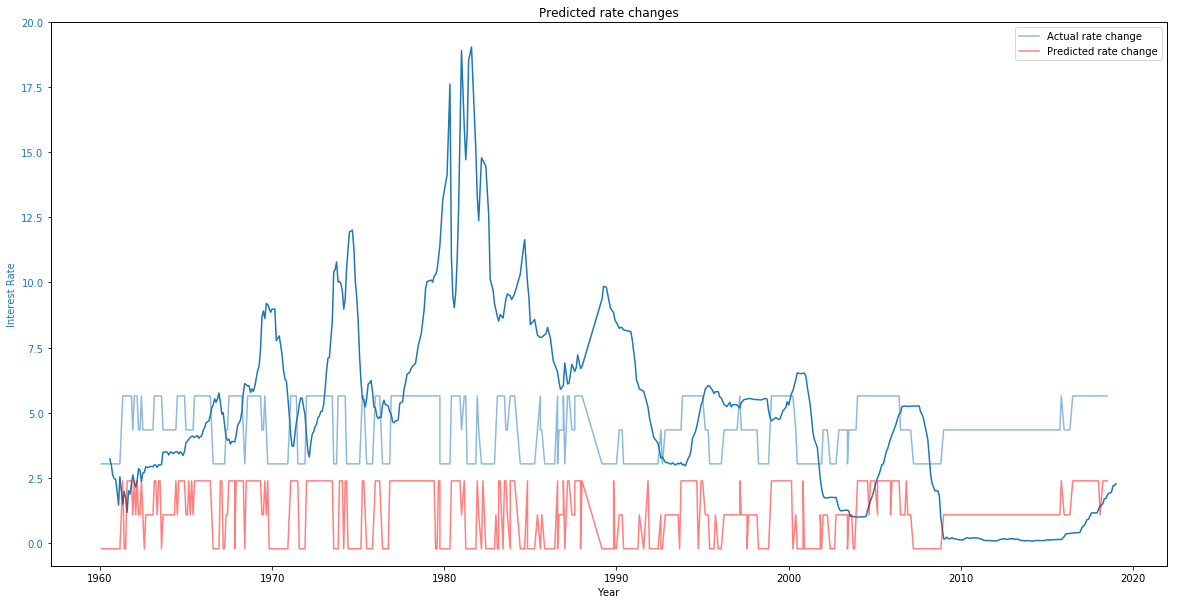

In [242]:
## Plot the interest rate, actual change, predicted change

fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest Rate', color=color)
ax1.plot(df_temp[6:].index, df_temp['rate'][6:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.set_ylim(bottom=-4, top=12)
ax2.get_yaxis().set_visible(False)

color = 'tab:blue'
ax2.set_ylabel('Interest Rate Change', color=color) 
ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label='Actual rate change')
ax2.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2.plot(y_pred['change_6_pred'], color=color, alpha=0.5, label='Predicted rate change')
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
plt.title('Predicted rate changes')
plt.show()

### 07: Final Model Tuning and Partial Data Testing
Currently the model is sitting at about 65% accuracy, when trained on a random 75% train sample and predicting a remaining 25% random test split.  <br>
<br>
Currently each observation is considered to be independent of all other observations, no time series data is considered.  Interest rate flow is inherently time series data, each new observation will have some degree of influence on future ones.  For the final model tuning, we'll add a time series component to the model by performing a train/test split based on a time point, then adding a moving average component to smooth out the results.  We'll review results with and without the moving average.<br>
<br>
The model may currently be fitting to non-ideal data such as proper names or document names.  The Beige Book is a relatively new PDF document title that's been running for serveral years, the model may for example be looking for "Beige Book" to predict a flat interest rate.  By removing long periods of recent data, we'll see how this affects the prediction accuracy of recent periods.

1. Re-import data
2. Model creation, testing
3. Plotting results

In [225]:
text = text_tfidf.copy()

In [226]:
## XGBoost model fitting and testing

def xgb_function(text_partial, y_partial, text, y):
    xgb_model = XGBClassifier(objective='multi:softmax',
                              max_depth=3,
                              num_classes=3)
    
    # Show performance scores for the partial set
    train_scores = []
    test_scores = []
    for x in range(1,4):
        X_train, X_test, y_train, y_test = train_test_split(text_partial, y_partial)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)

        test_score = round(xgb_model.score(X_test, y_test),2)
        train_score = round(xgb_model.score(X_train, y_train),2)
        print(f'Run {x}... train: {train_score}, test: {test_score}')
        train_scores.append(train_score)
        test_scores.append(test_score)
    print(f'Train partial set average: {np.mean(train_scores)}')
    print(f'Test partial set average: {np.mean(test_scores)}')
    
    # Show performance scores for the full set
    y_pred = xgb_model.predict(text)

    full_score = round(xgb_model.score(text, y),2)
    print(f'Full data run: {full_score}')
    
    # Plot predictions on the full dataset
    y_pred = y.copy()
    y_pred['change_6_pred'] = xgb_model.predict(text)
    y_pred['change_6_pred'] = y_pred['change_6_pred']-2.5
    y_pred['change_6'] = y_pred['change_6']
    
    
    fig, ax1 = plt.subplots(figsize=(20, 10))

    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Interest Rate', color=color)
    ax1.plot(df_temp[6:].index, df_temp['rate'][6:], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    ax2.set_ylim(bottom=-4, top=12)
    ax2.get_yaxis().set_visible(False)

    color = 'tab:blue'
    ax2.set_ylabel('Interest Rate Change', color=color)  
    ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label='Actual rate change')
    ax2.tick_params(axis='y', labelcolor=color)

    color = 'red'
    ax2.plot(y_pred['change_6_pred'], color=color, alpha=0.5, label='Predicted rate change')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.legend()
    plt.title('Predicted rate changes - Partial Dataset Training')
    plt.show()
    
    return None

In [227]:
## Manual train split
y_partial = y.loc[:'2008-01-01']
y_partial.shape[0]

537

In [228]:
text_partial = text.loc[:y_partial.shape[0]-1]
text_partial.shape

(537, 6000)

Run 1... train: 1.0, test: 0.63
Run 2... train: 1.0, test: 0.59
Run 3... train: 1.0, test: 0.64
Train partial set average: 1.0
Test partial set average: 0.62
Full data run: 0.83


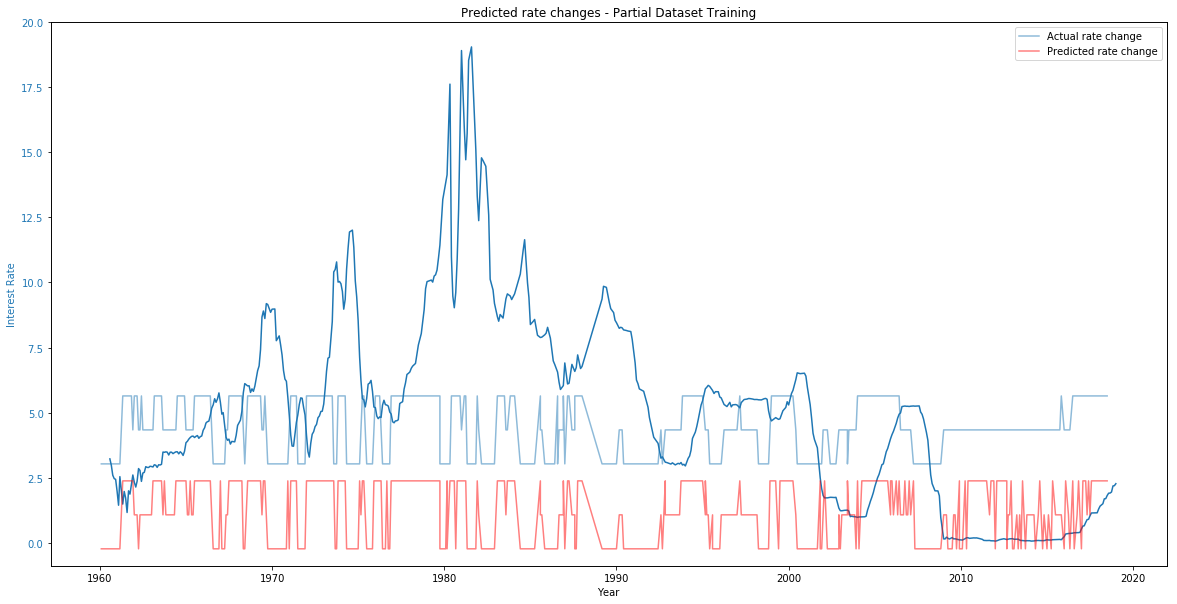

In [229]:
xgb_function(text_partial, y_partial, text, y)

#### 08: Review of Results and Moving Average Addition
In the above example, the model was trained only using data from before 2008.  The overall accuracy was improved, around 80%.  Model was still given a train/test split, so it was only provided with 75% of the data observations before 2008.  The post-2008 accuracy is quite poor, with high-volitility predictions.  If we average out the predictions, it may actually result in a strong model, despite not seeing any recent data observations.  This may fall under the realm of curve-fitting (adjusting the predictions manually to fit the actual data, based on what we know about the true data), so we'll preform two tests to see how much data it needs in the past to create reasonable future predictions.

1. Create y-target with moving average
2. Plot predictions
3. Review accuracy score

In [230]:
y_pred = y.copy()
y_pred['change_6_pred'] = xgb_model.predict(text) # Predict the full text, using the previous model only trained before 2008
y_pred['change_6'] = y_pred['change_6']
y_pred['change_6_pred_r'] = y_pred['change_6_pred'].rolling(2, min_periods=1).mean().round(0)
y_pred.head(10)

,change_6,change_6_pred,change_6_pred_r
date,,,
1960-02-01,-1.0,-1.0,-1.0
1960-03-01,-1.0,0.0,-0.0
1960-04-01,-1.0,-1.0,-0.0
1960-05-01,-1.0,-1.0,-1.0
1960-06-01,-1.0,-1.0,-1.0
1960-07-01,-1.0,-1.0,-1.0
1960-08-01,-1.0,-1.0,-1.0
1960-09-01,-1.0,-1.0,-1.0
1960-10-01,-1.0,-1.0,-1.0


In [231]:
# Stagger predicted line so it's not overlapping the actual change line

y_pred['change_6_pred_r_s'] = y_pred['change_6_pred_r'] - 2.5

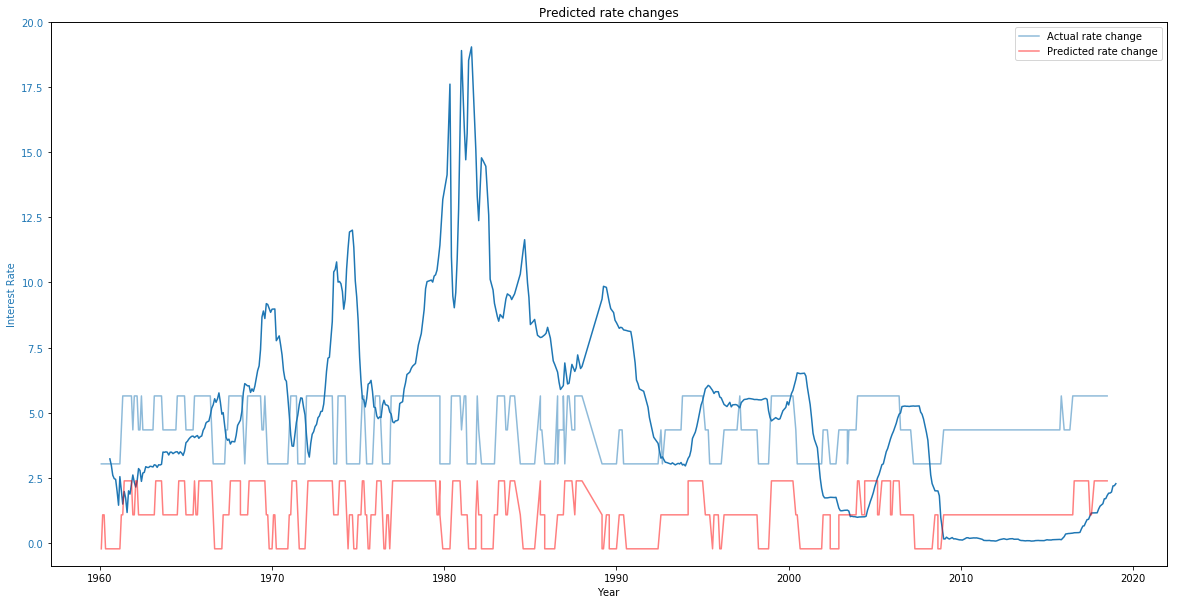

In [232]:
## Plot the interest rate, actual change, predicted change

fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest Rate', color=color)
ax1.plot(df_temp[6:].index, df_temp['rate'][6:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
ax2.set_ylim(bottom=-4, top=12)
ax2.get_yaxis().set_visible(False)

color = 'tab:blue'
ax2.set_ylabel('Interest Rate Change', color=color)  
ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label='Actual rate change')
ax2.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2.plot(y_pred['change_6_pred_r_s'], color=color, alpha=0.5, label='Predicted rate change')
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
plt.title('Predicted rate changes')
plt.show()

In [233]:
## Manual calculation of score
# Sum predictions
y_count = y_pred.shape[0]

# Sum correct predictions
y_pred_correct = y_pred[y_pred['change_6']==y_pred['change_6_pred_r']].shape[0]

# Percentage that was correct
accuracy = y_pred_correct / y_count
print(accuracy)

0.8495297805642633


#### 09: Decreasing the Training Sample
With the moving average, we're at around 80% accuracy.  This show that it's much less likely the model needs to rely on proper nouns or other non-ideal overfit data from recent periods.  The model's predictions were quite erratic, finding highly mixed signals in the past 10 years.  By using a rolling average, it not only successfully identified the flat interest rate period post-2008, but is also currently correctly identifying the quantitative easing period we are currently in.<br>
<br>
Again this is leaning towards curve-fitting.  We'll use a smaller training set, every up to January 1 2000, to see if it can correctly ride out two recessions and forecast rate changes before they actually happen.  The moving average will still be used.

1. Create new sample, split at year 2000
2. Score and plot without moving average
3. Score and plot with moving average

Run 1... train: 1.0, test: 0.62
Run 2... train: 1.0, test: 0.59
Run 3... train: 1.0, test: 0.72
Train partial set average: 1.0
Test partial set average: 0.6433333333333333
Full data run: 0.77


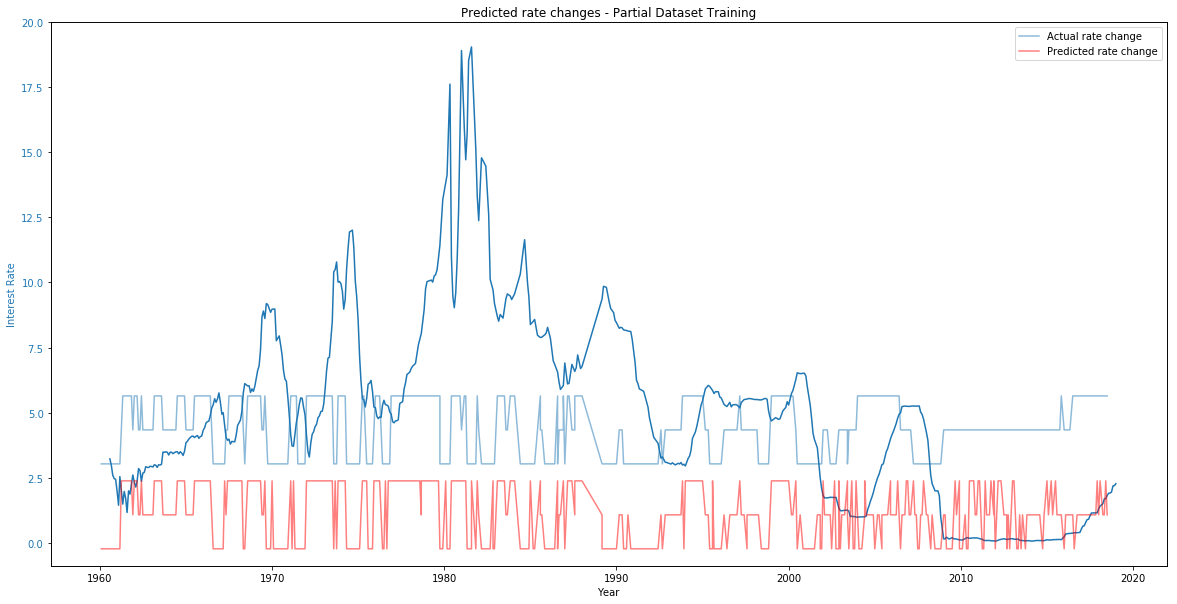

In [234]:
y_partial = y.loc[:'2000-01-01']
text_partial = text.loc[:y_partial.shape[0]-1]
xgb_function(text_partial, y_partial, text, y)

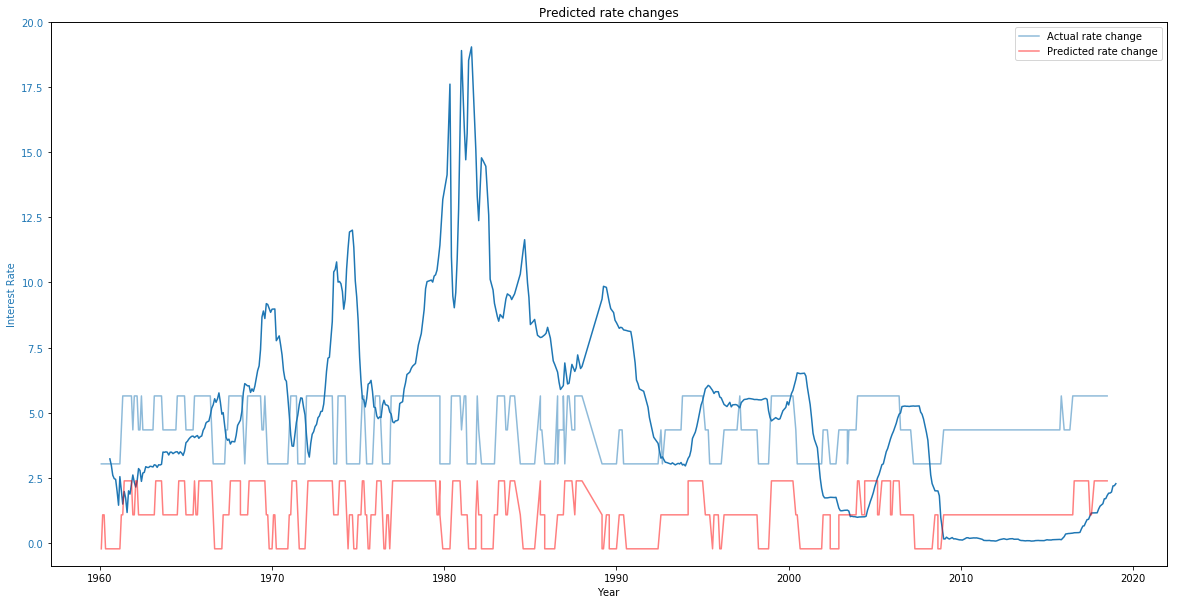

In [235]:
y_pred = y.copy()
y_pred['change_6_pred'] = xgb_model.predict(text)
y_pred['change_6'] = y_pred['change_6']
y_pred['change_6_pred_r'] = y_pred['change_6_pred'].rolling(2, min_periods=1).mean().round(0)
y_pred['change_6_pred_r_s'] = y_pred['change_6_pred_r'] - 2.5
## Plot the interest rate, actual change, predicted change

fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest Rate', color=color)
ax1.plot(df_temp[6:].index, df_temp['rate'][6:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
ax2.set_ylim(bottom=-4, top=12)
ax2.get_yaxis().set_visible(False)

color = 'tab:blue'
ax2.set_ylabel('Interest Rate Change', color=color)  
ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label='Actual rate change')
ax2.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2.plot(y_pred['change_6_pred_r_s'], color=color, alpha=0.5, label='Predicted rate change')
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
plt.title('Predicted rate changes')
plt.show()

In [236]:
## Manual calculation of score
# Sum predictions
y_count = y_pred.shape[0]

# Sum correct predictions
y_pred_correct = y_pred[y_pred['change_6']==y_pred['change_6_pred_r']].shape[0]

# Percentage that was correct
accuracy = y_pred_correct / y_count
print(accuracy)

0.8495297805642633


### 10: Final Model Review and Conclusion
In the above example, the model was trained on all data before the year 2000, then predictions were created for all available data.  The results were still quite good, just above 80%, despite not having any training information on documents for almost 20 years.  When the prediction volitility is smoothed out with a moving average, the results there still quite good.  It was able to predict major interest rate environment changes of the 2000 recession, 2008 recession, and the quantitative tightening environment that began a few years ago.  <br>
<br>
The final recommended usage of the model would be a manual train/test split, going back 10-20 years, ensuring it isn't fitting current day predictions to features such as proper nouns.<br>
<br>
As of February 2019, the model is still predicting increasing rates.  A flat signal for more than one month would be a useful and legitimate flag that a recession or at least easing rate environment may be approaching within the next 6 months.